In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models
from sklearn.utils import shuffle
import cv2

2024-11-20 00:02:37.720533: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 00:02:37.771016: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-20 00:02:38.524116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df=pd.read_csv("/raid/coss35/nahyun/study/dataset/ageutk_full.csv")

In [3]:
df[:5]

,files,age,gender
0,26_0_2_20170104023102422.jpg.chip.jpg,26,0
1,22_1_1_20170112233644761.jpg.chip.jpg,22,1
2,21_1_3_20170105003215901.jpg.chip.jpg,21,1
3,28_0_0_20170117180555824.jpg.chip.jpg,28,0
4,17_1_4_20170103222931966.jpg.chip.jpg,17,1


In [4]:
df.loc[(df.age<=49) & (df.age>=20), ['files','age','gender']]

,files,age,gender
0,26_0_2_20170104023102422.jpg.chip.jpg,26,0
1,22_1_1_20170112233644761.jpg.chip.jpg,22,1
2,21_1_3_20170105003215901.jpg.chip.jpg,21,1
3,28_0_0_20170117180555824.jpg.chip.jpg,28,0
5,44_0_3_20170119201022260.jpg.chip.jpg,44,0
...,...,...,...
23152,30_0_4_20170103235622469.jpg.chip.jpg,30,0
23153,38_1_2_20170109132801338.jpg.chip.jpg,38,1
23159,26_1_0_20170111182452795.jpg.chip.jpg,26,1
23163,41_0_0_20170109012220690.jpg.chip.jpg,41,0


In [5]:
data=df['files']
target=df['gender']

In [6]:
print(len(data))

23168


In [7]:
data[:5]

0    26_0_2_20170104023102422.jpg.chip.jpg
1    22_1_1_20170112233644761.jpg.chip.jpg
2    21_1_3_20170105003215901.jpg.chip.jpg
3    28_0_0_20170117180555824.jpg.chip.jpg
4    17_1_4_20170103222931966.jpg.chip.jpg
Name: files, dtype: object

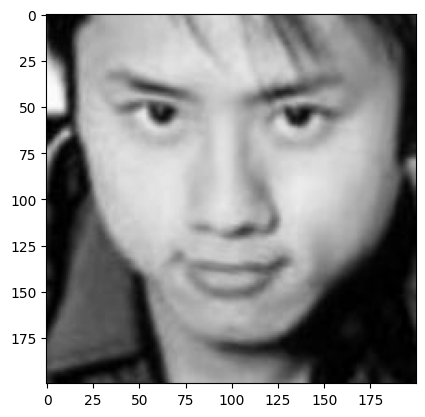

In [9]:
# 데이터프레임에서 파일 경로 가져오기
data = df['files']  # pandas.Series
target = df['gender']

# 첫 번째 파일 경로 가져오기
base_path = "/raid/coss35/nahyun/study/dataset/UTKFace/UTKFace/UTKFace/"
image_path = base_path + data.iloc[0] # Series에서 안전하게 첫 번째 값 가져오기

# 이미지 로드
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 이미지 로드 확인
#print(f"Image type: {type(image)}")
image = image.astype(np.float32) / 255.0
plt.imshow(image, cmap="gray")
plt.show()


In [10]:
xtrain=[]

# 첫 번째 파일 경로 가져오기
base_path = "/raid/coss35/nahyun/study/dataset/UTKFace/UTKFace/UTKFace/"

for i in range(len(data)):
    image_path=base_path+data.iloc[i]
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = image.astype(np.float32) / 255.0
    xtrain.append(image)

x_img_np = np.array(xtrain) 

In [11]:
target.to_numpy()

array([0, 1, 1, ..., 0, 1, 0])

In [12]:
print(target)

0        0
1        1
2        1
3        0
4        1
        ..
23163    0
23164    0
23165    0
23166    1
23167    0
Name: gender, Length: 23168, dtype: int64


In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_img_np, target, test_size=0.3, stratify=target, random_state=2018)

In [15]:
x_train = x_train.reshape(( -1,200, 200, 1)).astype('float32') / 255.0
x_test = x_test.reshape((-1,200, 200, 1)).astype('float32') / 255.0

In [16]:
# Model Creation
model = models.Sequential()

# First Convolutional Block
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200,200,1)))
model.add(layers.MaxPooling2D((2, 2)))

# Second Convolutional Block
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Third Convolutional Block
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten and Dense Layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification output

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

2024-11-20 00:03:53.854610: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=64,
                    validation_data=(x_test, y_test))

# Evaluate the model

Epoch 1/10
254/254 [==============================] - 678s 3s/step - loss: 0.6924 - accuracy: 0.5236 - val_loss: 0.6917 - val_accuracy: 0.5270
Epoch 2/10
254/254 [==============================] - 687s 3s/step - loss: 0.6919 - accuracy: 0.5269 - val_loss: 0.6917 - val_accuracy: 0.5270
Epoch 3/10
254/254 [==============================] - 689s 3s/step - loss: 0.6917 - accuracy: 0.5269 - val_loss: 0.6917 - val_accuracy: 0.5270
Epoch 4/10
254/254 [==============================] - 689s 3s/step - loss: 0.6917 - accuracy: 0.5269 - val_loss: 0.6917 - val_accuracy: 0.5270
Epoch 5/10
254/254 [==============================] - 689s 3s/step - loss: 0.6918 - accuracy: 0.5269 - val_loss: 0.6917 - val_accuracy: 0.5270
Epoch 6/10
254/254 [==============================] - 689s 3s/step - loss: 0.6918 - accuracy: 0.5269 - val_loss: 0.6917 - val_accuracy: 0.5270
Epoch 7/10
254/254 [==============================] - 690s 3s/step - loss: 0.6917 - accuracy: 0.5269 - val_loss: 0.6917 - val_accuracy: 0.5270

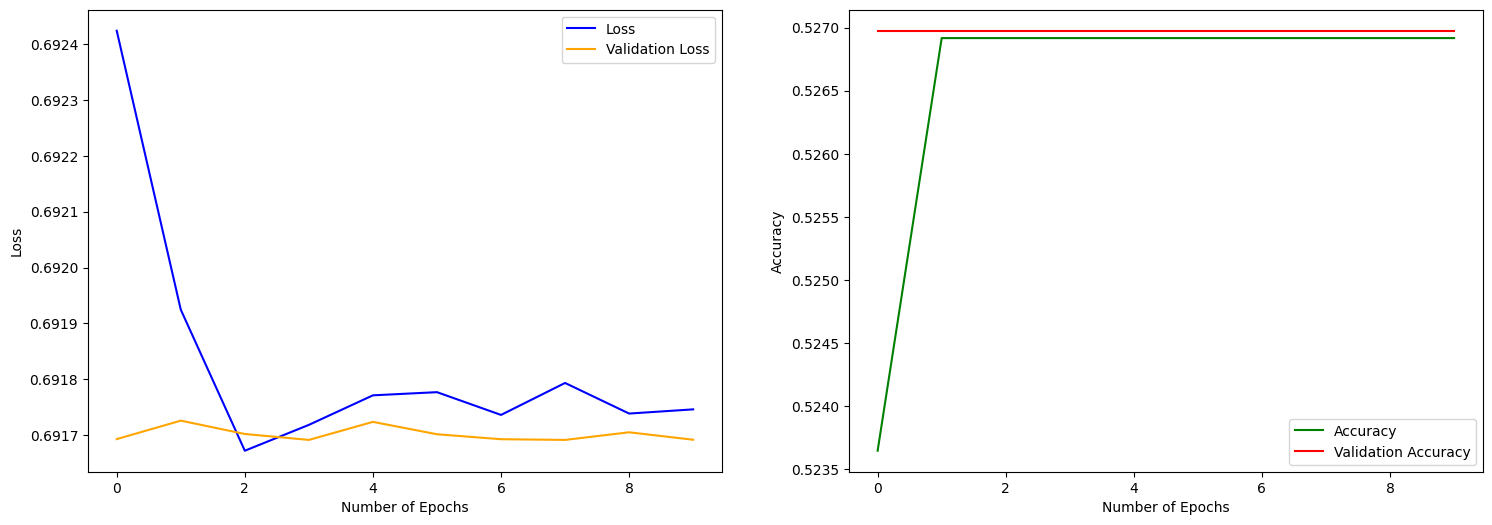

In [27]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], color="blue", label = "Loss")
plt.plot(history.history['val_loss'], color="orange", label = "Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], color="green", label = "Accuracy")
plt.plot(history.history['val_accuracy'], color="red", label = "Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")
plt.legend()

plt.show()

In [30]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

218/218 [==============================] - 78s 357ms/step - loss: 0.6917 - accuracy: 0.5270


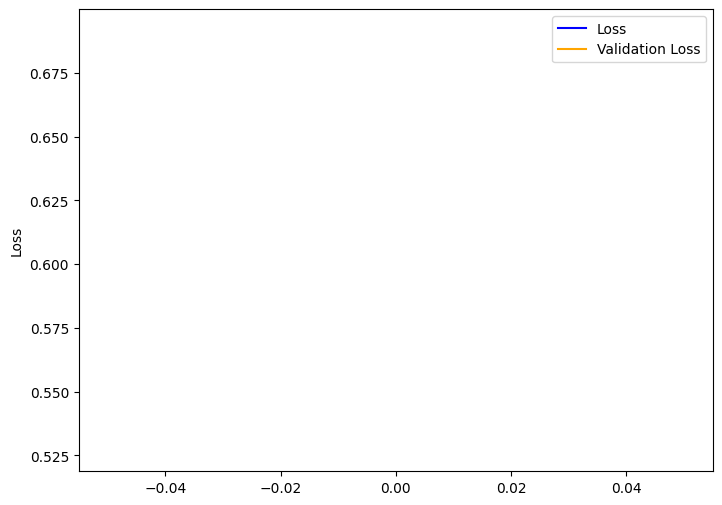

In [32]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(test_acc, color="blue", label = "Loss")
plt.plot(test_loss, color="orange", label = "Validation Loss")
plt.ylabel("Loss")
plt.legend()


plt.show()

In [28]:
model.save("CNN_model.h5")

/raid/coss35/anaconda3/envs/finetun/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
import cv2
import numpy as np

# 이미지 로드 (그레이스케일로 로드)
image_path = "/raid/coss35/nahyun/study/dataset/test.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 이미지 크기 확인 및 리사이징
target_size = (200, 200)  # 모델에서 기대하는 입력 크기
image_resized = cv2.resize(image, target_size)

# 차원을 추가하여 (200, 200) -> (200, 200, 1)로 만듦
image_resized = np.expand_dims(image_resized, axis=-1)

# 배치 차원을 추가하여 (200, 200, 1) -> (1, 200, 200, 1)로 만듦
image_resized = np.expand_dims(image_resized, axis=0)

# 정규화 (픽셀 값을 0~1 사이로 스케일링)
image_resized = image_resized.astype(np.float32) / 255.0

In [ ]:
# Make predictions on the test set
predictions = model.predict(image_resized)

# 0 : man, 1 : female
# For binary classification, you can use a threshold of 0.5
pred_classes = (predictions > 0.5).astype(int).flatten()  # Flatten to 1D array
print(pred_classes)

1/1 [==============================] - 0s 163ms/step
[0]
